In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, wishart
from scipy.special import digamma
import data, random

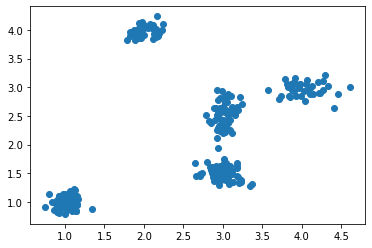

In [2]:
centers_x = [1, 2,   3,   3, 4]
centers_y = [1, 4, 1.5, 2.5, 3]
covs = [np.array([[1, 0],[0, 1]]), 
        np.array([[2, 0.3],[0.3, 1]]),
        np.array([[2, -0.3],[-0.3, 1]]),
        np.array([[1, 0.3],[0.3, 6]]), 
        np.array([[5, 0.1],[0.1, 2]])]
datanums = [60, 40, 80, 60, 40]

K = 10

data = []

for i in range(5):
    p = multivariate_normal((centers_x[i], centers_y[i]), covs[i]/100)
    data.extend(p.rvs(datanums[i]))
    
#random.shuffle(data)
data.sort(key = lambda x: x[0])
#print(data)

plt.scatter([x for (x,y) in data], [y for (x,y) in data])


In [3]:

def initial_r(data):
    rs = []
    for i,d in enumerate(data):
        r = [0]*K
        p = int(i/len(data)*K)
        r[p] = 1.0
        
        rs.append(r)
        
    return rs

In [4]:
rs = initial_r(data)

In [5]:
def weighted_num(k, rs):
    return sum([r[k] for r in rs])

def weighted_mean(k, rs, data):
    return sum([ r[k]*p for (r, p) in zip(rs, data)])/weighted_num(k, rs)
    
def weighted_cov(k, rs, data):
    xbar = weighted_mean(k, rs, data)
    return sum([ r[k]*(p-xbar).reshape((2, 1)).dot((p-xbar).reshape((2, 1)).T) for (r, p) in zip(rs, data)])/weighted_num(k, rs)

In [6]:
def update_params(org_alpha, org_beta, org_nu, org_m, org_w_inv, k, ns, xs, covs):
    alpha = org_alpha + ns[k]
    beta = org_beta + ns[k]
    nu = org_nu + ns[k]
    m = (org_beta * org_m + ns[k]*xs[k])/beta
    w_inv = org_w_inv + ns[k]*covs[k] + (org_beta*ns[k])/(org_beta + ns[k])*(xs[k] - org_m).reshape((2,1)).dot((xs[k] - org_m).reshape((2,1)).T)
    
    return (alpha, beta, nu, m, w_inv)

In [7]:
def rho(d, k, alphas, betas, nus, ms, w_invs):
    first = digamma(alphas[k]) - digamma(sum(alphas))
    second_2 = digamma((nus[k])/2) + digamma((nus[k] - 1)/2) + np.log(1/np.linalg.det(w_invs[k]))
    third_2 = 2/betas[k] + nus[k]*(d - ms[k]).reshape((2,1)).T.dot(np.linalg.inv(w_invs[k])).dot((d - ms[k]).reshape((2,1)))[0][0]
    
    log_rho = first + second_2/2 - third_2/2
    
    return np.exp(log_rho)

In [8]:
def calc_rs(alphas, betas, nus, ms, w_invs):
    rs = []
    for d in data:
        rhos = [ rho(d, k, alphas, betas, nus, ms, w_invs) for k in range(K)]
        sm = sum(rhos)
        rs.append(rhos/sm)
        
    return rs

In [9]:
def graph(data, ms, betas, w_invs, ns):
    plt.scatter([x for (x,y) in data], [y for (x,y) in data])
    plt.scatter([x for (x,y) in ms], [y for (x,y) in ms], color="red")
    sigmas = [ w_invs[k]/betas[k]/2 for k in range(K)]
    
    normals = [multivariate_normal(mean=ms[k], cov=sigmas[k]) for k in range(K) ]
    
    x, y = np.mgrid[0:5:100j, 0:4:100j]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x 
    pos[:, :, 1] = y 

    for k,n in enumerate(normals):
        if ns[k] > 1:
            plt.contour(x, y, n.pdf(pos), levels=3) 
    

In [10]:
alphas = [1]*K
betas = [1]*K
nus = [1]*K
ms = [np.array([0,0])]*K
w_invs = [np.array([[1, 0],[0, 1]])]*K

In [11]:

def one_step(rs):
    ns = [weighted_num(k, rs) for k in range(K)]
    xs = [weighted_mean(k, rs, data) for k in range(K)]
    covs = [weighted_cov(k, rs, data) for k in range(K)]

    print(ns)
    for k in range(K):
        if ns[k] < 0.01:
         #   ms[k] = np.array([0,0])
            continue
            
        params = update_params(1,1,1, np.array([0,0]), np.array([[1, 0],[0, 1]]), k, ns, xs, covs)
        alphas[k] = params[0]
        betas[k] = params[1]
        nus[k] = params[2]
        ms[k] = params[3]
        w_invs[k] = params[4]

    
    graph(data, ms, betas, w_invs, ns)
    return calc_rs(alphas, betas, nus, ms, w_invs)
    
#    print(alphas)
#    print(betas)
#    print(nus)

#    print(w_invs)
#    print(ms) 
#    print(rs)

[28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0]


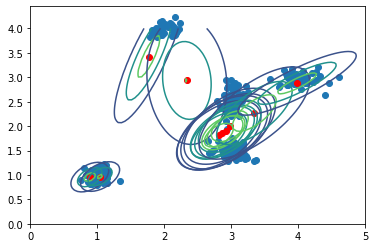

In [12]:
rs = one_step(rs)

In [13]:
print(ms)

[array([0.88979429, 0.95591353]), array([1.04392329, 0.9674021 ]), array([1.77215026, 3.42336293]), array([2.3400072 , 2.93451735]), array([2.8158538 , 1.81467173]), array([2.86954577, 1.86060449]), array([2.92378102, 1.89462253]), array([2.98019535, 1.99662778]), array([3.34795706, 2.26768869]), array([3.98603887, 2.87545384])]


[28.913054921525344, 29.740001162827134, 30.44997604586502, 18.50739189973191, 28.03150844629334, 28.586322325509062, 28.923954373954224, 29.207084460636594, 27.73095661960193, 29.90974974405539]
[29.07708868021318, 30.28310563489463, 36.22084779211267, 8.936874581981192, 28.58153710947072, 29.18679258568742, 29.491411378228715, 29.537111346009606, 26.54422935953375, 32.14100153186811]
[28.624187349801748, 30.64751041282252, 39.409862743078556, 2.9527227961647236, 29.069840917019814, 29.732914450031508, 30.003393366631734, 29.685969877759643, 24.982293820187923, 34.89130426650185]
[27.90298393286353, 31.403126426387928, 39.96741229589537, 0.589251832860882, 29.321797502917107, 30.05151858984964, 30.282194321214604, 29.460358383774544, 22.849484544616537, 38.17187216961984]
[26.643865280402146, 32.71635650970975, 39.999933712012385, 0.017253119654543733, 29.296442049270734, 30.097396739342244, 30.27132403865054, 28.769129451739616, 20.03995756652053, 42.14834153269746]
[24.4382957284000

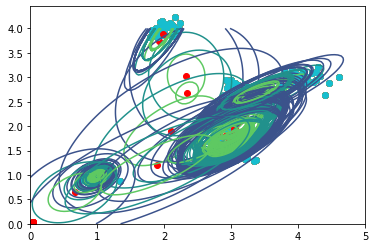

In [14]:
for _ in range(10):
    rs = one_step(rs)

[0.08405765990637562, 59.546960006264705, 39.99987247720449, 2.404305869883184e-28, 27.86353481930383, 29.08206935652698, 26.972237592262783, 13.078667461071559, 0.21059450801318003, 83.16200611944608]


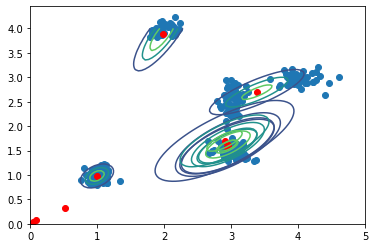

In [15]:
rs = one_step(rs)